# **Project: NLP Document Classification**

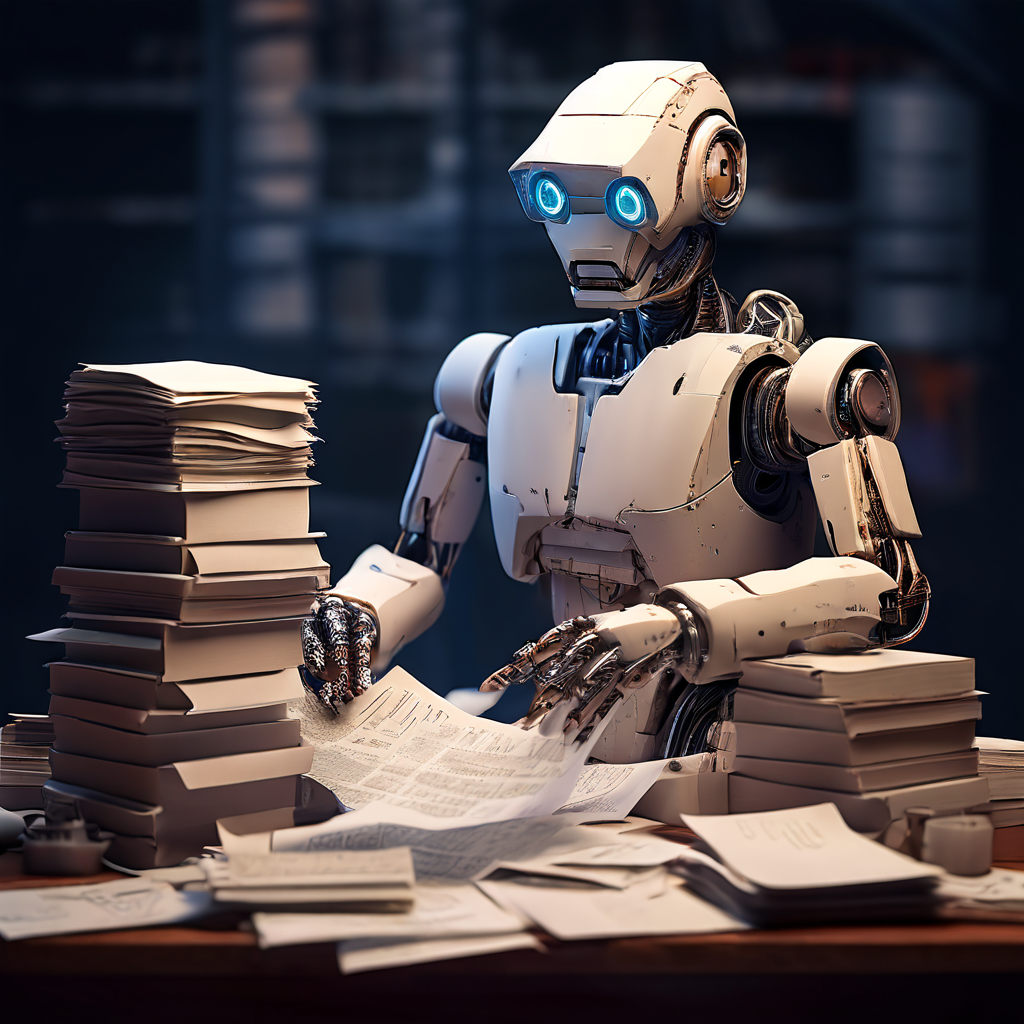

## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import pandas as pd
import numpy as np
import tarfile
import matplotlib.pyplot as plt
import spacy
import pickle
import string
import nltk
import re
from scipy import sparse

from collections import Counter
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#from textblob import TextBlob
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Dataset Exploration

In [ ]:
# Extract the dataset
tar = tarfile.open("/content/drive/MyDrive/datasets/20_newsgroups.tar.gz")
tar.extractall()
tar.close()

In [ ]:
# Define the directory containing the extracted dataset
dataset_dir = "./20_newsgroups"

# Initialize variables to count observations, newsgroups, and files
total_observations = 0
total_newsgroups = 0
observations_per_group = {}

# Traverse through the directory structure
for category in os.listdir(dataset_dir):
    category_path = os.path.join(dataset_dir, category)
    # Check if the category is a directory (newsgroup)
    if os.path.isdir(category_path):
        total_newsgroups += 1
        # Count the number of files (observations) in each newsgroup
        category_files = os.listdir(category_path)
        num_observations = len(category_files)
        observations_per_group[category] = num_observations
        # Increment the total number of observations
        total_observations += num_observations

# Calculate the size of the data
data_size = sum(os.path.getsize(os.path.join(root, file))
                for root, _, files in os.walk(dataset_dir)
                for file in files)

# Print the summary statistics
print("Dataset Exploration")
print("\nTotal number of observations:", total_observations)
print("\nTotal number of newsgroups:", total_newsgroups)
print("\nNumber of observations per newsgroup:")
for group, num_observations in observations_per_group.items():
    print(f"{group}: {num_observations}")
print("\nSize of the data (in bytes):", data_size)

Dataset Exploration

Total number of observations: 19997

Total number of newsgroups: 20

Number of observations per newsgroup:
rec.sport.hockey: 1000
sci.med: 1000
misc.forsale: 1000
alt.atheism: 1000
rec.sport.baseball: 1000
rec.autos: 1000
comp.sys.ibm.pc.hardware: 1000
rec.motorcycles: 1000
talk.politics.mideast: 1000
talk.politics.misc: 1000
talk.politics.guns: 1000
talk.religion.misc: 1000
comp.windows.x: 1000
sci.space: 1000
comp.graphics: 1000
comp.sys.mac.hardware: 1000
comp.os.ms-windows.misc: 1000
sci.crypt: 1000
soc.religion.christian: 997
sci.electronics: 1000

Size of the data (in bytes): 46132928


This balanced distribution ensures that there is no bias towards any particular category during the analysis.

## Data Preprocessing

In [ ]:
# Initialize an empty list to store newsgroups and content
data = []

# Traverse through the directory structure
for category in os.listdir(dataset_dir):
    category_path = os.path.join(dataset_dir, category)
    # Iterate through files in each category
    for file_name in os.listdir(category_path):
        file_path = os.path.join(category_path, file_name)
        # Read the content of the file
        with open(file_path, 'r', errors='ignore') as file:
            content = file.read()
            # Append newsgroup and content to the list
            data.append((category, content))

# Create a DataFrame from the list of newsgroups and content
df = pd.DataFrame(data, columns=['Newsgroup', 'Original_Content'])
df

Newsgroup                                   Original_Content
0      rec.sport.hockey  Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...
1      rec.sport.hockey  Newsgroups: rec.sport.hockey\nPath: cantaloupe...
2      rec.sport.hockey  Newsgroups: rec.sport.hockey\nPath: cantaloupe...
3      rec.sport.hockey  Newsgroups: rec.sport.hockey\nPath: cantaloupe...
4      rec.sport.hockey  Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...
...                 ...                                                ...
19992   sci.electronics  Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv....
19993   sci.electronics  Newsgroups: sci.electronics\nPath: cantaloupe....
19994   sci.electronics  Newsgroups: sci.electronics\nFrom: tchannon@bl...
19995   sci.electronics  Xref: cantaloupe.srv.cs.cmu.edu comp.robotics:...
19996   sci.electronics  Newsgroups: sci.electronics\nPath: cantaloupe....

[19997 rows x 2 columns]

In [ ]:
# Check DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19997 entries, 0 to 19996
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Newsgroup         19997 non-null  object
 1   Original_Content  19997 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


In [ ]:
# Check for null values
df.isnull().sum()

Newsgroup           0
Original_Content    0
dtype: int64

In [ ]:
# Check the shape of the dataset
print("Shape of the DataFrame:", df.shape)

Shape of the DataFrame: (19997, 2)


In [ ]:
print(df["Original_Content"][1500])

Xref: cantaloupe.srv.cs.cmu.edu sci.research:4033 sci.med:58154 alt.psychoactives:2253 sci.psychology:11783
Newsgroups: sci.research,sci.med,alt.psychoactives,sci.psychology
Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!zaphod.mps.ohio-state.edu!uwm.edu!ux1.cso.uiuc.edu!usenet.ucs.indiana.edu!jh224-718622.ucs.indiana.edu!user
From: bshelley@ucs.indiana.edu ()
Subject: Xanax...please provide info
Message-ID: <bshelley-060493181020@jh224-718622.ucs.indiana.edu>
Followup-To: sci.research,sci.med,alt.psychoactives,sci.psychology
Sender: news@usenet.ucs.indiana.edu (USENET News System)
Nntp-Posting-Host: jh224-718622.ucs.indiana.edu
Organization: Indiana University
Date: Tue, 6 Apr 1993 23:15:26 GMT
Lines: 9

I am currently doing a group research project on the drug Xanax.  I would
be exponentially gracious to receive any and all information you could
provide
me regarding its usage, history, mechanism of reaction, side 

## Text Preprocessing

In [ ]:
def preprocess_text(text):
    # Remove metadata headers
    text = re.sub(r'^.*?:.*?\n', '', text, flags=re.MULTILINE)

    # Remove emails
    text = re.sub(r'\S*@\S*\s?', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove 'GMT'
    text = re.sub(r'GMT', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Lowercasing
    tokens = [token.lower() for token in tokens]

    # Removing Punctuation and non-alphabetic characters
    tokens = [token for token in tokens if token.isalpha()]

    # Remove single characters
    tokens = [token for token in tokens if len(token) > 1]

    # Removing Stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back into a string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

- Remove metadata headers: Metadata headers are removed using regular expressions. This step removes lines that start with any characters followed by a colon and any characters until a newline character \n. This is used to remove headers like "From:", "Subject:", etc.

- Remove emails: It matches any sequence of non-whitespace characters followed by an "@" symbol and then again any sequence of non-whitespace characters. This helps in removing email addresses which may not be relevant for text analysis.

- Remove numbers: Regular expression \d+ is used to match and remove any sequence of digits from the text. This is done to remove numerical digits which may not be relevant for text analysis or could introduce noise.

- Remove 'GMT': The string 'GMT' is removed from the text. This is done to remove timestamps or time zone indicators which may not be relevant for text analysis.

- Tokenization: The text is tokenized into individual words using the word_tokenize function from the NLTK library. Tokenization is the process of splitting text into smaller units, such as words or phrases.

- Lowercasing: All tokens are converted to lowercase using list comprehension. This ensures that words are treated consistently regardless of their original casing.

- Removing Punctuation and non-alphabetic characters: Tokens that contain only alphabetic characters are retained, while tokens containing any non-alphabetic characters (such as punctuation marks) are removed. This step helps in removing noise from the text data.

- Remove single characters: Tokens with a length of 1 (single characters) are removed. This is done to filter out single letters or other very short words that may not carry much semantic meaning.

- Removing Stopwords: Stopwords, which are commonly occurring words that do not carry much significance (e.g., 'the', 'is', 'and'), are removed from the tokens using a predefined set of stopwords from the NLTK library.

- Lemmatization: Each token is lemmatized using WordNetLemmatizer from NLTK, which reduces words to their base or dictionary form. This helps in standardizing tokens and reducing the dimensionality of the feature space.

- Join tokens back into a string: Finally, the preprocessed tokens are joined back into a single string, separated by whitespace, and returned as the preprocessed text.

Overall, these preprocessing steps aim to clean and standardize the text data, making it more suitable for text analysis tasks such as classification or clustering.

In [ ]:
# Apply preprocessing function to the 'Original_Content' column
df['Content_prep'] = df['Original_Content'].apply(preprocess_text)

In [ ]:
df["Content_prep"][1500]

'currently group research project drug xanax would exponentially gracious receive information could provide regarding usage history mechanism reaction side effect pertinent information care long short response thanks advance brent shelley'

In [ ]:
df["Content_prep"][100]

'felix potvin deserves sh kicked anyone hitting stick pussy defensemen seem move big dino ciccerelli lb front net obviously toronto realized overmatched wing must rely trying antagonize superior red wing cheap shot prefer watch hockey seeing shot felix potvin slashing spearing dino ciccerelli standing front net every right stand front net crease yes goalie sure hell want played roller hockey boy miss day goalie would scream defense clear guy slot care crease get hell away see ball yes roller hockey remember nobody around clear slot pushing offending player hard hate people way goalie sure felix say see incident potvin really swung stick big time right move people keith keller let go ranger ivy league champ corner let go quaker weighing almost every weight imaginable life surround blue traveler'

In [ ]:
df["Content_prep"][880]

'person rarely even seen cherry know anything know whether area pittsburgh usa deprived broadcast whether canadian thing altogether seriously know coach one time volume post someone surely getting steady diet somehow question deal secondly comment read net merely flame bait people actually take seriously got ta tell see really sound like as let know maybe missing something'

In [ ]:
df["Content_prep"][8000]

'believe zionism form racism mean fact nacionalism specific idea support form defines jew way want accomplish goal nothing hypocrisy everything hypocrisy dealt succeeded convincing anyone probably lack basis want convince anyone usenet real world read opinion others subject sometimes present opinion think net useful exchange idea never wanted want convince anyone anything want deal certain people say fine condemning movement nothing jewish nationalism never anything saying quite literally racist think jew people added right state homeland right every nation agree suggest read dictionary interpretation plain inconsistent dictionary definition well modern history first repeat never said idea jew right state racist zionism movement idea think zionism way defines jew example way believe irish right nationalism support bombing killing ira believe jew right nationalism support zionism right wrong also know wrong zionism way monolithic never approach zionism widespread ideology hashomer hatza

In [ ]:
df["Content_prep"][18500]

'anyone english translation long recension act apostle found act apostle translated codex bezae introduction lucan origin importance wilson london act apostle critical edition introduction note selected passage albert clark oxford reprinted edition text act make assumption text codex bezae authentic know actually contains english translation theological tendency codex bezae cantabrigiensis act eldon epp cambridge recent reference found edition french early supply reference anyone interested many work going difficult find interested examining difference long recension textual commentary greek nt bruce metzger united bible society metzger book serf companion volume ubs rd edition greek nt contains discussion reasoning went behind decision variant reading included ubs furthermore note addition reading included atcotgnt majority occur act attempt made set reader le full report english translation several addition modification attested western witness since many corresponding apparatus care

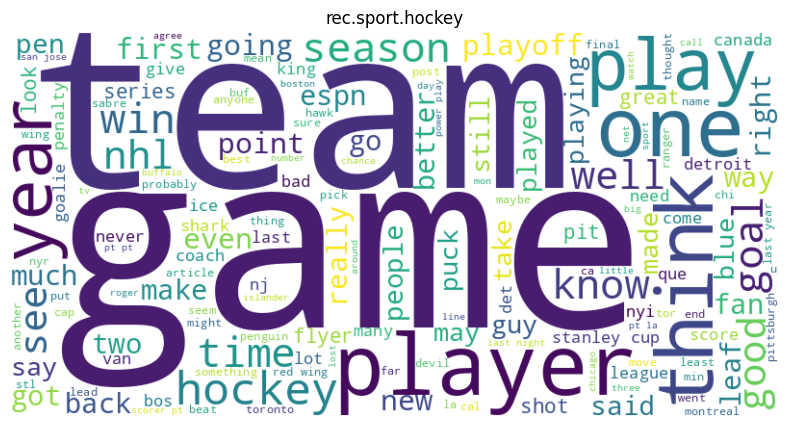

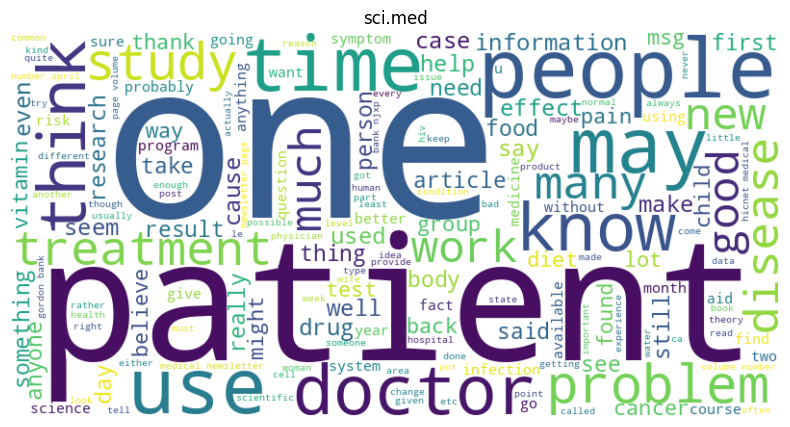

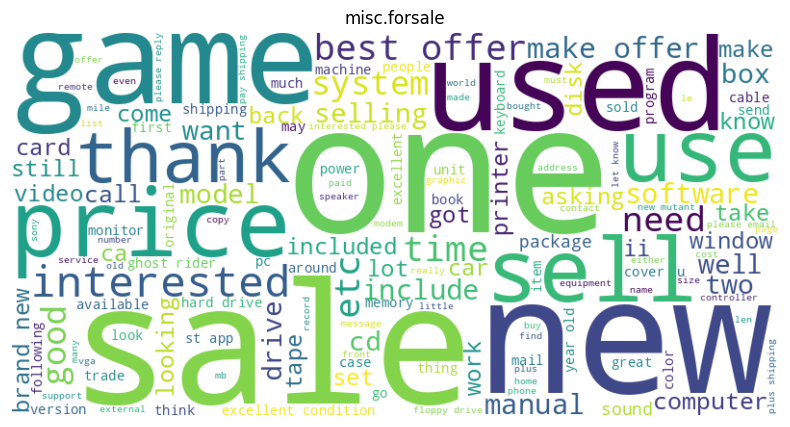

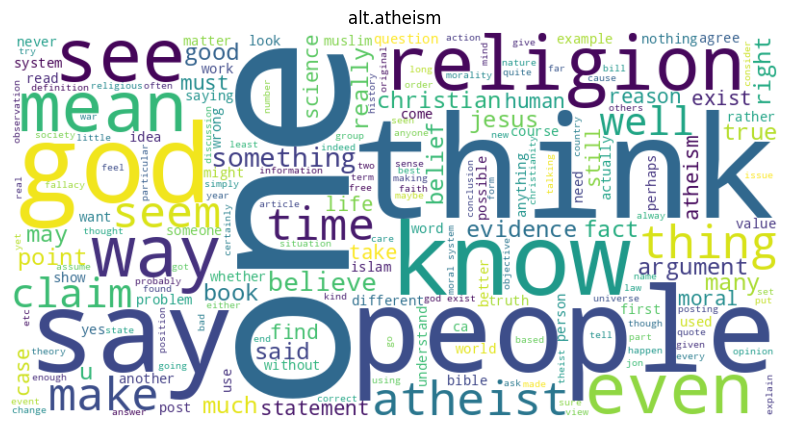

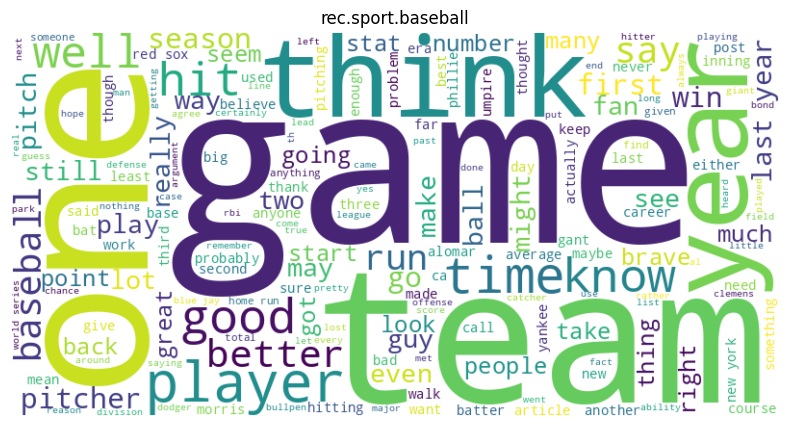

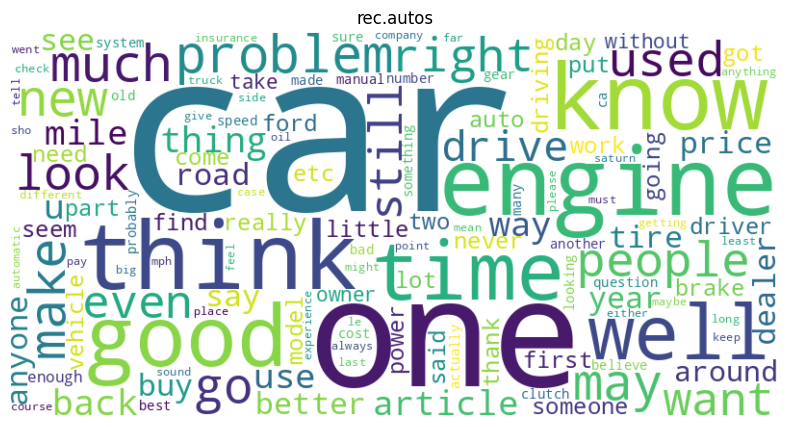

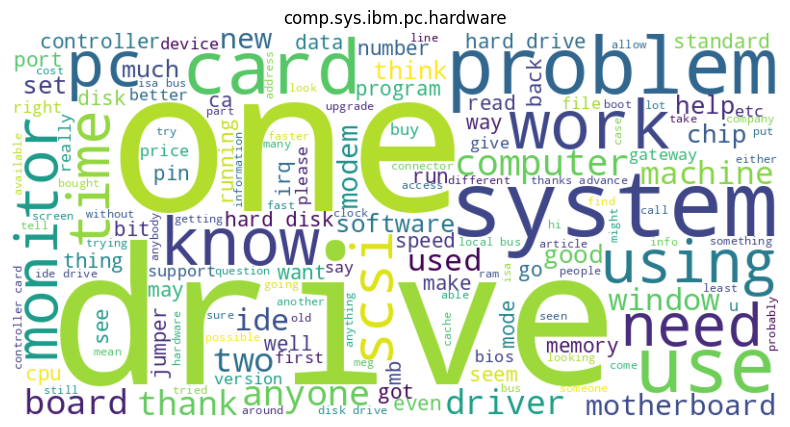

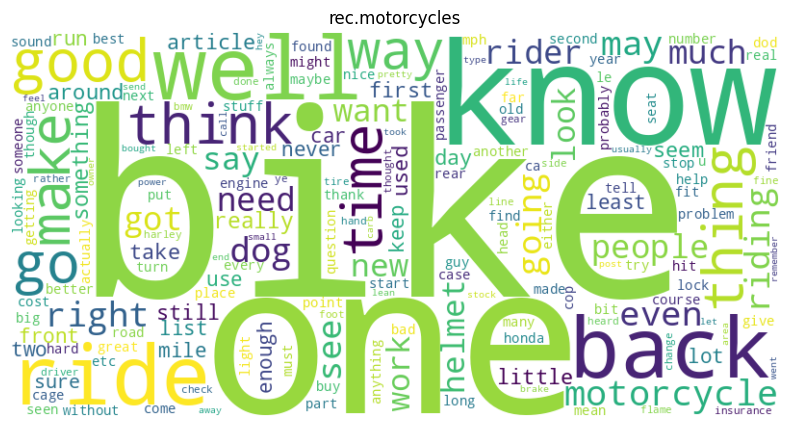

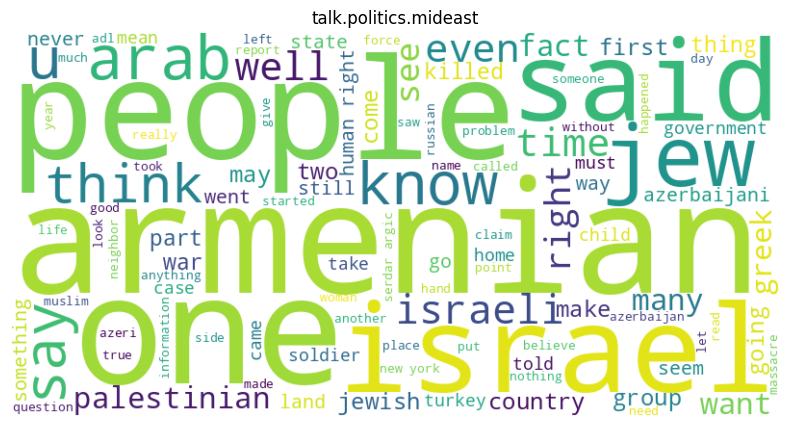

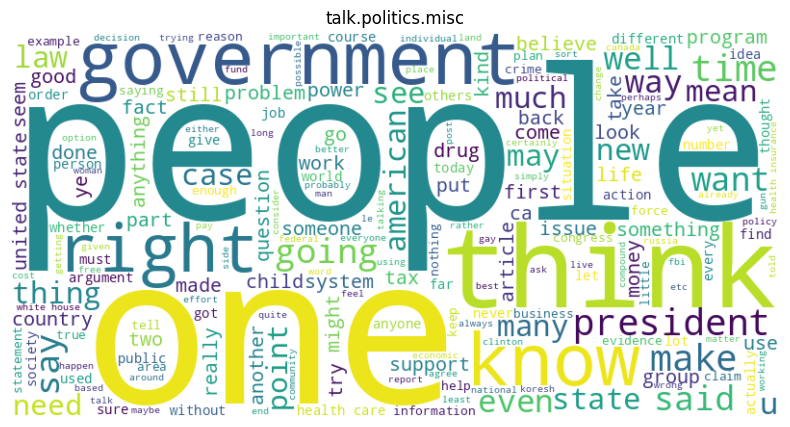

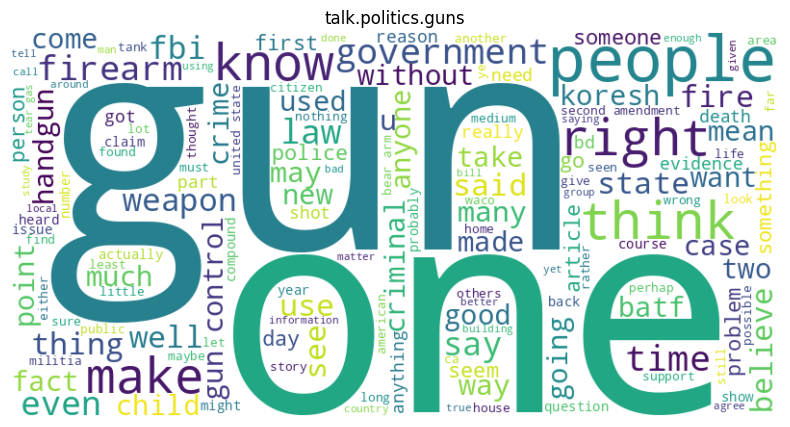

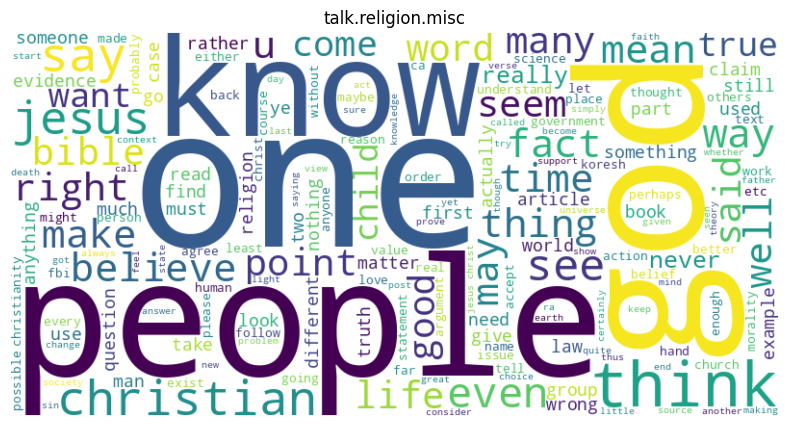

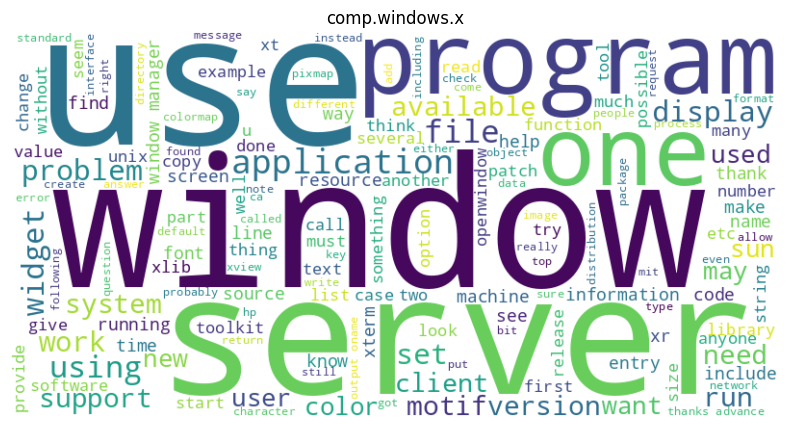

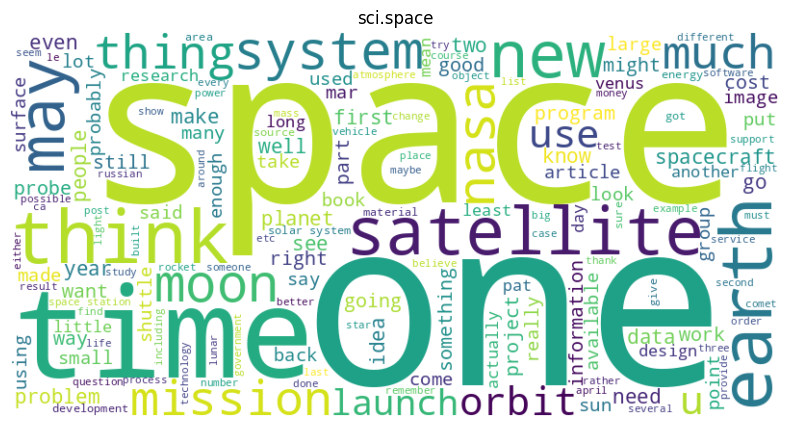

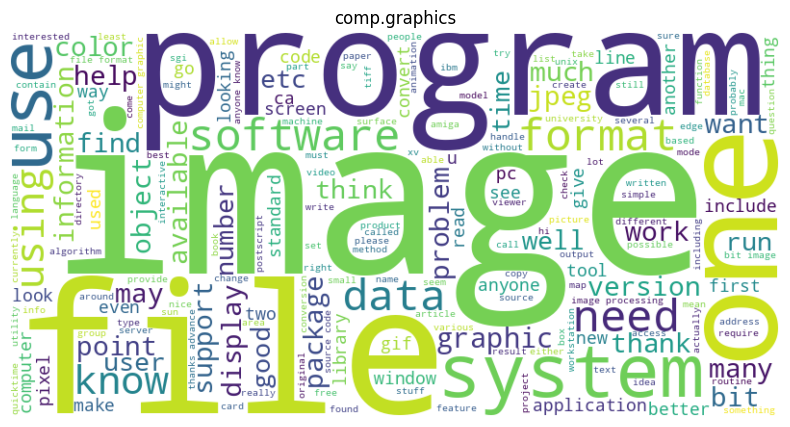

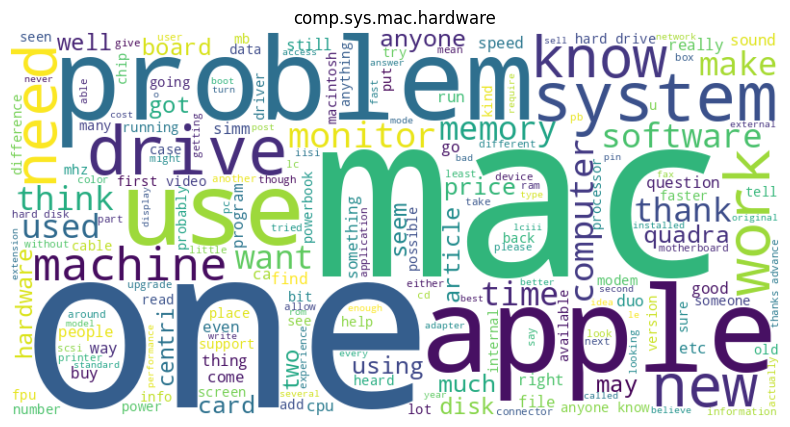

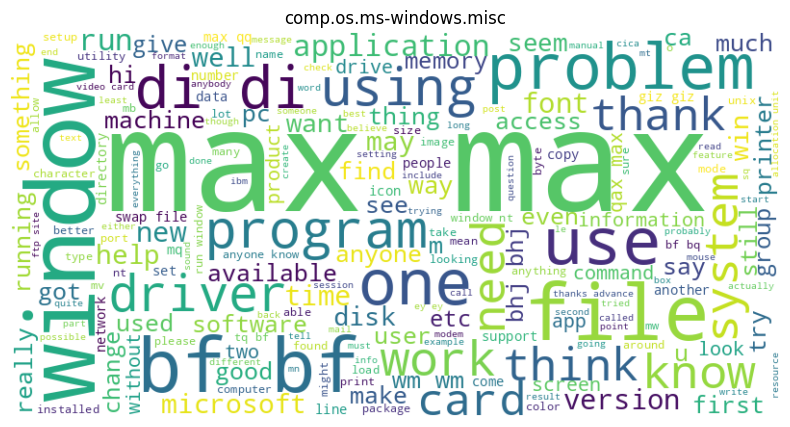

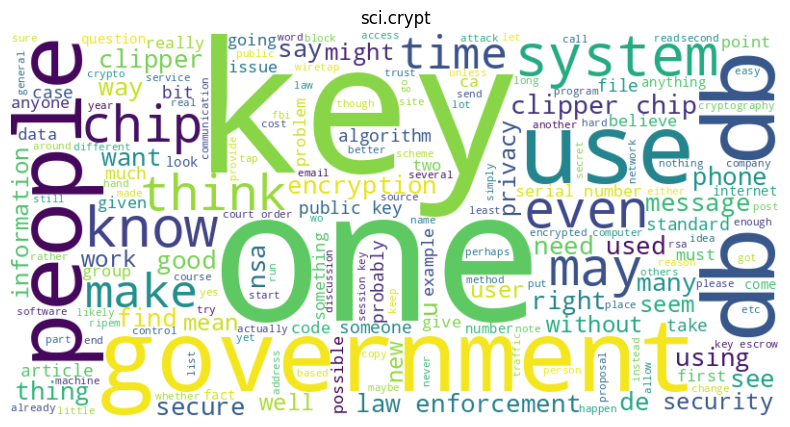

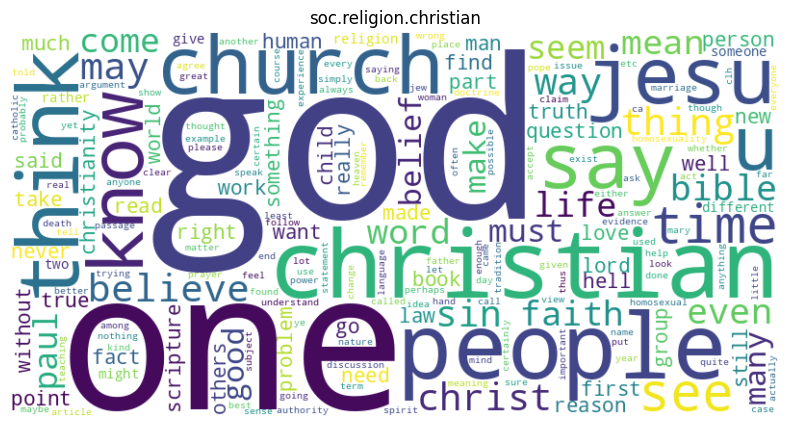

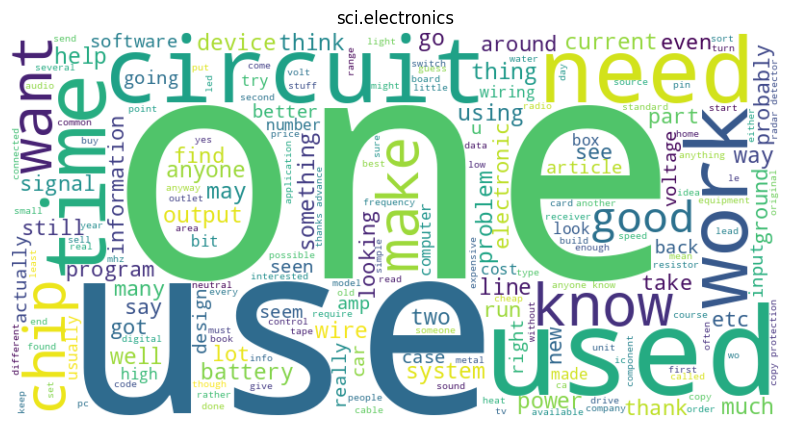

In [ ]:
# Generate WordCloud for each Newsgroup
for group in df['Newsgroup'].unique():
    text = ' '.join(df[df['Newsgroup'] == group]['Content_prep'])
    wordcloud = WordCloud(width=800, height=400, background_color ='white', min_font_size = 10).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(group)
    plt.axis('off')
    plt.show()

## Text Preprocessing using SpaCy

In [ ]:
# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")

In [ ]:
def preprocess_text_spacy(text):
    # Remove metadata headers
    text = re.sub(r'^.*?:.*?\n', '', text, flags=re.MULTILINE)

    # Remove emails
    text = re.sub(r'\S*@\S*\s?', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove 'GMT'
    text = re.sub(r'GMT', '', text)

    # Remove extra whitespace and newline characters
    text = re.sub(r'\s+', ' ', text)

    # Apply spaCy tokenization and lemmatization
    doc = nlp(text)

    # Lemmatize tokens, lowercase and remove stopwords, punctuation and special characters
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and token.text.isalnum()]

    # Join tokens back into a string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

In [ ]:
# Apply spaCy preprocessing to the 'Content' column
df['Content_spacy'] = df['Original_Content'].apply(preprocess_text_spacy)

In [ ]:
df['Content_spacy'][1500]

'currently group research project drug xanax exponentially gracious receive information provide usage history mechanism reaction effect pertinent information care long short response thank advance brent shelley'

In [ ]:
df['Content_spacy'][100]

'felix potvin deserve kick hit stick pussy defenseman big dino ciccerelli lbs net obviously toronto realize overmatche wings rely try antagonize superior red wings cheap shot prefer watch hockey see shot felix potvin slash spear dino ciccerelli stand net right stand net crease yes goalie sure hell want play roller hockey boy miss day goalie scream defense clear guy slot care crease hell away ball yes roller hockey remember clear slot push offending hate people way goalie sure felix incident potvin swing stick big time right people keith keller let ranger ivy league champs corner let quakers weigh weight imaginable life surround blues traveler'

In [ ]:
df['Content_spacy'][880]

'person rarely see don cherry know know area pittsburgh usa deprive broadcast canadian thing altogether seriously know coach time volume post surely get steady diet question deal secondly comment read net merely flame bait people actually seriously get to tell sound like ass let know maybe miss'

In [ ]:
df['Content_spacy'][8000]

'believe zionism form racism mean fact nacionalism specific idea support form define jew way want accomplish goal hypocrisy hypocrisy deal succeed convince probably lack basis want convince usenet real world read opinion subject present opinion think net useful exchange idea want want convince want deal certain people fine condemn movement jewish nationalism say literally racist think jews people add right state homeland right nation agree suggest read dictionary interpretation plain inconsistent dictionary definition modern history repeat say idea jews have right state racist zionism movement idea think zionism way define jew example racist like way believe irish right nationalism support bombing killing ira believe jews right nationalism support zionism right wrong know wrong zionism way monolithic approach zionism widespread ideology hashomer hatzair meir kahane approach racist kahane approach zionism define goal differently define different approach goal single commonality belief j

In [ ]:
df['Content_spacy'][18500]

'english translation long recension act apostles find act apostles translate codex bezae introduction lucan origin importance wilson london act apostles critical edition introduction notes selected passages albert clark oxford reprint edition text act make assumption text codex bezae authentic know actually contain english translation theological tendency codex bezae cantabrigiensis acts eldon j epp cambridge recent reference find edition french early supply reference interested work go difficult find interested examine difference long recension textual commentary greek nt bruce metzger united bible society metzger book serve companion volume ubs rd edition greek nt contain discussion reasoning go decision variant reading include ubs furthermore note addition reading include atcotgnt majority occur acts attempt set reader report english translation addition modification attest western witness corresponding apparatus text volume care take supply adequate conspectus evidence support dive

## Comparison of the two methods

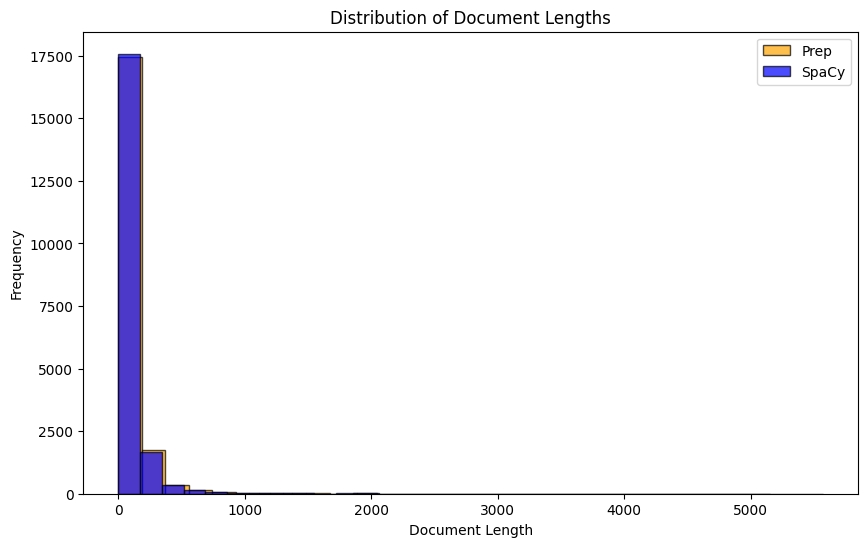

In [ ]:
# Visualize Document Length Distribution
df['Prep_Document_Length'] = df['Content_prep'].apply(lambda x: len(x.split()))
df['SpaCy_Document_Length'] = df['Content_spacy'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
plt.hist(df['Prep_Document_Length'], bins=30, color='orange', edgecolor='black', alpha=0.7, label='Prep')
plt.hist(df['SpaCy_Document_Length'], bins=30, color='blue', edgecolor='black', alpha=0.7, label='SpaCy')
plt.title('Distribution of Document Lengths')
plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
# Display most common words
word_counter = Counter()
for content in df['Content_prep']:
    words = content.split()
    word_counter.update(words)

most_common_words = word_counter.most_common(20)
print("\nMost Common Words in Preprocessed Content:", most_common_words)

word_counter = Counter()
for content in df['Content_spacy']:
    words = content.split()
    word_counter.update(words)

most_common_words = word_counter.most_common(20)
print("\nMost Common Words in SpaCy Content:", most_common_words)


Most Common Words in Preprocessed Content: [('would', 16216), ('one', 15072), ('people', 9881), ('like', 9479), ('know', 9084), ('get', 8754), ('time', 7730), ('think', 7646), ('also', 7117), ('could', 6510), ('use', 6416), ('make', 6262), ('say', 5999), ('right', 5878), ('good', 5600), ('year', 5568), ('way', 5507), ('even', 5503), ('system', 5451), ('new', 5370)]

Most Common Words in SpaCy Content: [('know', 10850), ('people', 9919), ('like', 9741), ('think', 9405), ('x', 8369), ('time', 7830), ('good', 7492), ('use', 7267), ('say', 6743), ('work', 6190), ('right', 5832), ('year', 5681), ('want', 5675), ('go', 5671), ('new', 5616), ('way', 5580), ('come', 5368), ('thing', 5339), ('look', 5261), ('find', 5128)]


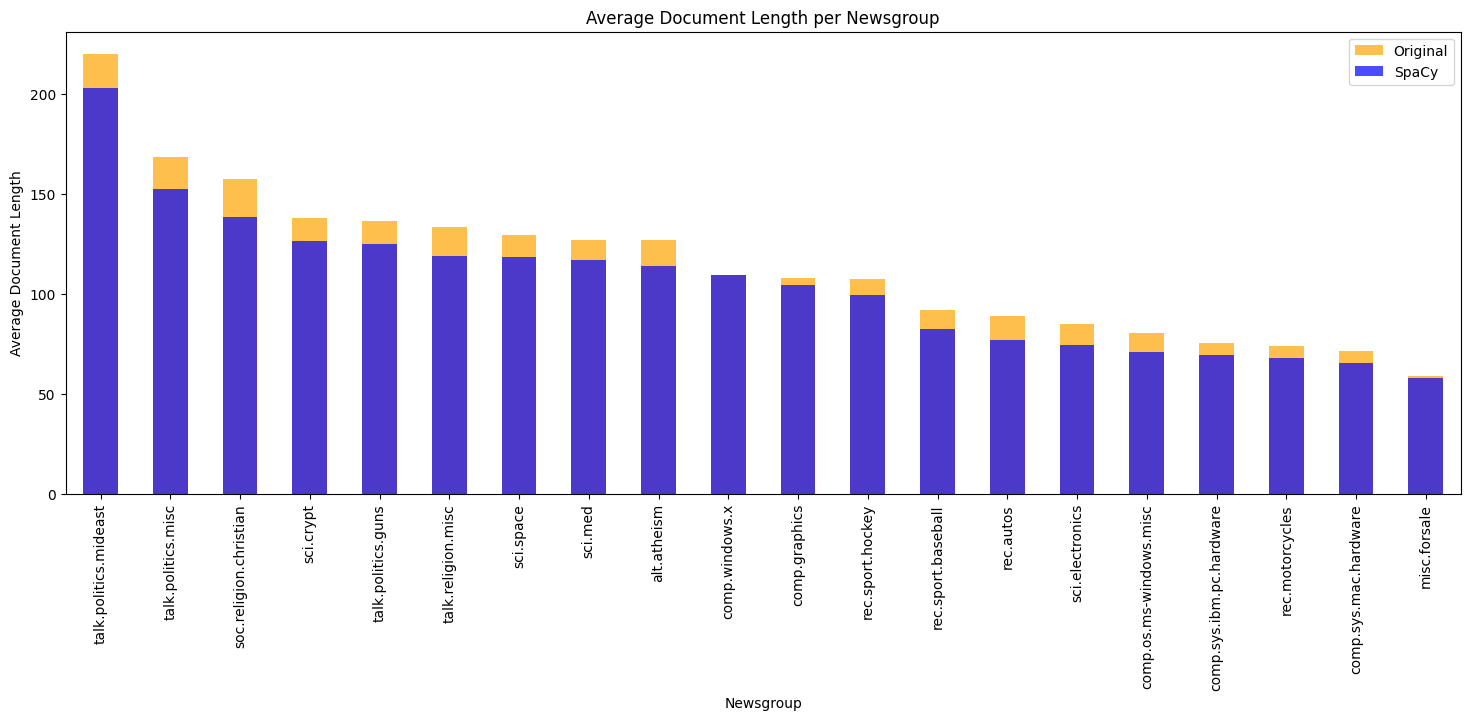

In [ ]:
# Display average document length per newsgroup
avg_doc_length_per_group = df.groupby('Newsgroup')['Prep_Document_Length'].mean().sort_values(ascending=False)
plt.figure(figsize=(18, 6))
avg_doc_length_per_group.plot(kind='bar', color='orange', alpha=0.7, label='Original')
avg_doc_length_per_group_spacy = df.groupby('Newsgroup')['SpaCy_Document_Length'].mean().sort_values(ascending=False)
avg_doc_length_per_group_spacy.plot(kind='bar', color='blue', alpha=0.7, label='SpaCy')
plt.title('Average Document Length per Newsgroup')
plt.xlabel('Newsgroup')
plt.ylabel('Average Document Length')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [ ]:
df.head()

Newsgroup                                   Original_Content  \
0  rec.sport.hockey  Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...   
1  rec.sport.hockey  Newsgroups: rec.sport.hockey\nPath: cantaloupe...   
2  rec.sport.hockey  Newsgroups: rec.sport.hockey\nPath: cantaloupe...   
3  rec.sport.hockey  Newsgroups: rec.sport.hockey\nPath: cantaloupe...   
4  rec.sport.hockey  Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...   

                                        Content_prep  \
0  full calder cup playoff schedule result home t...   
1  first anyone accepted western business school ...   
2  philadelphia buffalo first period second perio...   
3  standing game divisional series andrew usenet ...   
4  well compiled statistic entry pool unofficiall...   

                                       Content_spacy  Prep_Document_Length  \
0  calder cup playoff schedule results home team ...                    62   
1  accept western business school dork second per...                   110   
2  philadelphia buffalo period second period peri...                   194   
3  standing game divisional semi final series and...                   456   
4  compile statistic entry pool unofficially entr...                    76   

   SpaCy_Document_Length  
0                     60  
1                     88  
2                    193  
3                    457  
4                     69

## Save the preprocessed dataframe

In [ ]:
# Save the variable to a file using pickle
with open('df.pkl', 'wb') as f:
    pickle.dump(df, f)

In [ ]:
# Load the variable from the file
with open('df.pkl', 'rb') as f:
    df = pickle.load(f)

In [ ]:
df.head()

Newsgroup                                   Original_Content  \
0  rec.sport.hockey  Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...   
1  rec.sport.hockey  Newsgroups: rec.sport.hockey\nPath: cantaloupe...   
2  rec.sport.hockey  Newsgroups: rec.sport.hockey\nPath: cantaloupe...   
3  rec.sport.hockey  Newsgroups: rec.sport.hockey\nPath: cantaloupe...   
4  rec.sport.hockey  Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...   

                                        Content_prep  \
0  full calder cup playoff schedule result home t...   
1  first anyone accepted western business school ...   
2  philadelphia buffalo first period second perio...   
3  standing game divisional series andrew usenet ...   
4  well compiled statistic entry pool unofficiall...   

                                       Content_spacy  Prep_Document_Length  \
0  calder cup playoff schedule results home team ...                    62   
1  accept western business school dork second per...                   110   
2  philadelphia buffalo period second period peri...                   194   
3  standing game divisional semi final series and...                   456   
4  compile statistic entry pool unofficially entr...                    76   

   SpaCy_Document_Length  
0                     60  
1                     88  
2                    193  
3                    457  
4                     69

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19997 entries, 0 to 19996
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Newsgroup              19997 non-null  object
 1   Original_Content       19997 non-null  object
 2   Content_prep           19997 non-null  object
 3   Content_spacy          19997 non-null  object
 4   Prep_Document_Length   19997 non-null  int64 
 5   SpaCy_Document_Length  19997 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 937.5+ KB


## Modeling

In [ ]:
# Split the dataset into training, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)

In [ ]:
# Feature representation using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['Content_prep'])
X_val_tfidf = tfidf_vectorizer.transform(val_df['Content_prep'])

X_train_spacy_tfidf = tfidf_vectorizer.fit_transform(train_df['Content_spacy'])
X_val_spacy_tfidf = tfidf_vectorizer.transform(val_df['Content_spacy'])

In [ ]:
# Train and evaluate models
models = {
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(kernel='linear', probability=True)
}

In [ ]:
best_model = None
best_f1_score = 0
best_roc_auc_score = 0

for model_name, model in models.items():
    print(f"Training and evaluating {model_name} with TF-IDF features from original content...")

    # Train the model on TF-IDF features from original content
    model.fit(X_train_tfidf, train_df['Newsgroup'])

    # Predict on validation set
    y_val_pred = model.predict(X_val_tfidf)

    # Evaluate model performance
    print(f"Evaluation results for {model_name} with TF-IDF features from original content:")
    print(classification_report(val_df['Newsgroup'], y_val_pred))

    # Calculate F1-score
    f1_score = classification_report(val_df['Newsgroup'], y_val_pred, output_dict=True)['macro avg']['f1-score']
    print(f"F1-score: {f1_score}")

    # Calculate ROC-AUC score
    y_val_prob = model.predict_proba(X_val_tfidf)
    roc_auc = roc_auc_score(val_df['Newsgroup'], y_val_prob, average='macro', multi_class='ovo')
    print(f"ROC-AUC score: {roc_auc}")

    print("-" * 50)

    # Update best model if necessary
    if f1_score > best_f1_score or (f1_score == best_f1_score and roc_auc > best_roc_auc_score):
        best_model = (model_name, 'TF-IDF from original content')
        best_f1_score = f1_score
        best_roc_auc_score = roc_auc

Training and evaluating Naive Bayes with TF-IDF features from original content...
Evaluation results for Naive Bayes with TF-IDF features from original content:


                          precision    recall  f1-score   support

             alt.atheism       0.67      0.67      0.67       210
           comp.graphics       0.77      0.74      0.76       196
 comp.os.ms-windows.misc       0.75      0.73      0.74       189
comp.sys.ibm.pc.hardware       0.72      0.77      0.74       215
   comp.sys.mac.hardware       0.75      0.88      0.81       172
          comp.windows.x       0.84      0.82      0.83       172
            misc.forsale       0.90      0.59      0.71       206
               rec.autos       0.89      0.86      0.88       227
         rec.motorcycles       0.94      0.85      0.89       221
      rec.sport.baseball       0.96      0.96      0.96       203
        rec.sport.hockey       0.95      0.97      0.96       221
               sci.crypt       0.78      0.88      0.83       198
         sci.electronics       0.73      0.80      0.76       192
                 sci.med       0.94      0.86      0.90       210
         

In [ ]:
for model_name, model in models.items():
    print(f"Training and evaluating {model_name} with TF-IDF features from SpaCy preprocessed text...")

    # Train the model on TF-IDF features from SpaCy preprocessed text
    model.fit(X_train_spacy_tfidf, train_df['Newsgroup'])

    # Predict on validation set
    y_val_spacy_pred = model.predict(X_val_spacy_tfidf)

    # Evaluate model performance
    print(f"Evaluation results for {model_name} with TF-IDF features from SpaCy preprocessed text:")
    print(classification_report(val_df['Newsgroup'], y_val_spacy_pred))

    # Calculate F1-score
    f1_score_spacy = classification_report(val_df['Newsgroup'], y_val_spacy_pred, output_dict=True)['macro avg']['f1-score']
    print(f"F1-score: {f1_score_spacy}")

    # Calculate ROC-AUC score
    y_val_spacy_prob = model.predict_proba(X_val_spacy_tfidf)
    roc_auc_spacy = roc_auc_score(val_df['Newsgroup'], y_val_spacy_prob, average='macro', multi_class='ovo')
    print(f"ROC-AUC score: {roc_auc_spacy}")

    print("-" * 50)

    # Update best model if necessary
    if f1_score_spacy > best_f1_score or (f1_score_spacy == best_f1_score and roc_auc_spacy > best_roc_auc_score):
        best_model = (model_name, 'TF-IDF from SpaCy preprocessed text')
        best_f1_score = f1_score_spacy
        best_roc_auc_score = roc_auc_spacy

print(f"Best model based on F1-score and ROC-AUC: {best_model[0]} with {best_model[1]}")

Training and evaluating Naive Bayes with TF-IDF features from SpaCy preprocessed text...
Evaluation results for Naive Bayes with TF-IDF features from SpaCy preprocessed text:


                          precision    recall  f1-score   support

             alt.atheism       0.65      0.69      0.67       210
           comp.graphics       0.80      0.75      0.78       196
 comp.os.ms-windows.misc       0.76      0.77      0.77       189
comp.sys.ibm.pc.hardware       0.73      0.77      0.75       215
   comp.sys.mac.hardware       0.74      0.88      0.80       172
          comp.windows.x       0.84      0.82      0.83       172
            misc.forsale       0.88      0.57      0.69       206
               rec.autos       0.88      0.87      0.87       227
         rec.motorcycles       0.95      0.86      0.91       221
      rec.sport.baseball       0.96      0.95      0.96       203
        rec.sport.hockey       0.95      0.96      0.96       221
               sci.crypt       0.81      0.89      0.85       198
         sci.electronics       0.73      0.77      0.75       192
                 sci.med       0.94      0.86      0.90       210
         

In [ ]:
# Save the results to a dictionary
results = {
    'Best Model': best_model[0],
    'Feature Representation': best_model[1],
    'F1-score': best_f1_score,
    'ROC-AUC Score': best_roc_auc_score
}

# Convert results to a DataFrame for better organization
results_df = pd.DataFrame(results, index=[0])

# Save the results to a file using pickle
with open('results_df.pkl', 'wb') as f:
    pickle.dump(results_df, f)

# Save the best model to a file using pickle
with open('best_model.pkl', 'wb') as f:
    pickle.dump(models[best_model[0]], f)

In [ ]:
# # Load the variable from the file
# with open('results_df.pkl', 'rb') as f:
#     results_df = pickle.load(f)

# # Load the variable from the file
# with open('best_model.pkl', 'rb') as f:
#     best_model = pickle.load(f)

In [ ]:
results_df

Best Model               Feature Representation  F1-score  ROC-AUC Score
0        SVM  TF-IDF from SpaCy preprocessed text  0.811969       0.984551

In [ ]:
best_model

('SVM', 'TF-IDF from SpaCy preprocessed text')

## Hyperparameter tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameters for fine-tuning
param_dist = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

# Initialize RandomizedSearchCV for fine-tuning
random_search = RandomizedSearchCV(models[best_model[0]], param_dist, n_iter=10, cv=5, scoring='f1_macro', n_jobs=-1)

In [ ]:
# Combine training and validation sets for fine-tuning
X_train_val_spacy_tfidf = sparse.vstack([X_train_spacy_tfidf, X_val_spacy_tfidf])
y_train_val = pd.concat([train_df['Newsgroup'], val_df['Newsgroup']])

# Fit RandomizedSearchCV to the combined training and validation sets
random_search.fit(X_train_val_spacy_tfidf, y_train_val)

RandomizedSearchCV(cv=5, estimator=SVC(kernel='linear', probability=True),
                   n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   scoring='f1_macro')

In [ ]:
# Get the best parameters and best score
best_params = random_search.best_params_
best_score = random_search.best_score_
print("Best parameters:", best_params)
print("Best score:", best_score)

# Save the results to a file using pickle
with open('best_params.pkl', 'wb') as f:
    pickle.dump(best_params, f)

# Save the results to a file using pickle
with open('best_score.pkl', 'wb') as f:
    pickle.dump(best_score, f)

Best parameters: {'kernel': 'linear', 'C': 1}
Best score: 0.8171082037725308


In [ ]:
# Get the best fine-tuned model
best_fine_tuned_model = random_search.best_estimator_

# Transform the test set text data into TF-IDF features
X_test_spacy_tfidf = tfidf_vectorizer.transform(test_df['Content_spacy'])

# Evaluate the fine-tuned model on the test set
y_test_pred = best_fine_tuned_model.predict(X_test_spacy_tfidf)

# Print evaluation metrics for the test set
print("Evaluation results for the fine-tuned model on the test set:")
print(classification_report(test_df['Newsgroup'], y_test_pred))

# Calculate F1-score
f1_score_test = classification_report(test_df['Newsgroup'], y_test_pred, output_dict=True)['macro avg']['f1-score']
print(f"F1-score: {f1_score_test}")

# Calculate ROC-AUC score for the test set
y_test_prob = best_fine_tuned_model.predict_proba(X_test_spacy_tfidf)
roc_auc_test = roc_auc_score(test_df['Newsgroup'], y_test_prob, average='macro', multi_class='ovo')
print(f"ROC-AUC score on the test set: {roc_auc_test}")

Evaluation results for the fine-tuned model on the test set:
                          precision    recall  f1-score   support

             alt.atheism       0.73      0.70      0.72       204
           comp.graphics       0.71      0.75      0.73       205
 comp.os.ms-windows.misc       0.78      0.81      0.79       206
comp.sys.ibm.pc.hardware       0.68      0.73      0.71       190
   comp.sys.mac.hardware       0.88      0.81      0.84       215
          comp.windows.x       0.89      0.80      0.84       227
            misc.forsale       0.76      0.88      0.82       226
               rec.autos       0.92      0.83      0.87       186
         rec.motorcycles       0.92      0.92      0.92       203
      rec.sport.baseball       0.96      0.95      0.96       205
        rec.sport.hockey       0.98      0.97      0.98       173
               sci.crypt       0.96      0.87      0.91       197
         sci.electronics       0.75      0.81      0.78       176
              

In [ ]:
# Save the results to a file using pickle
with open('best_fine_tuned_model.pkl', 'wb') as f:
    pickle.dump(best_fine_tuned_model, f)

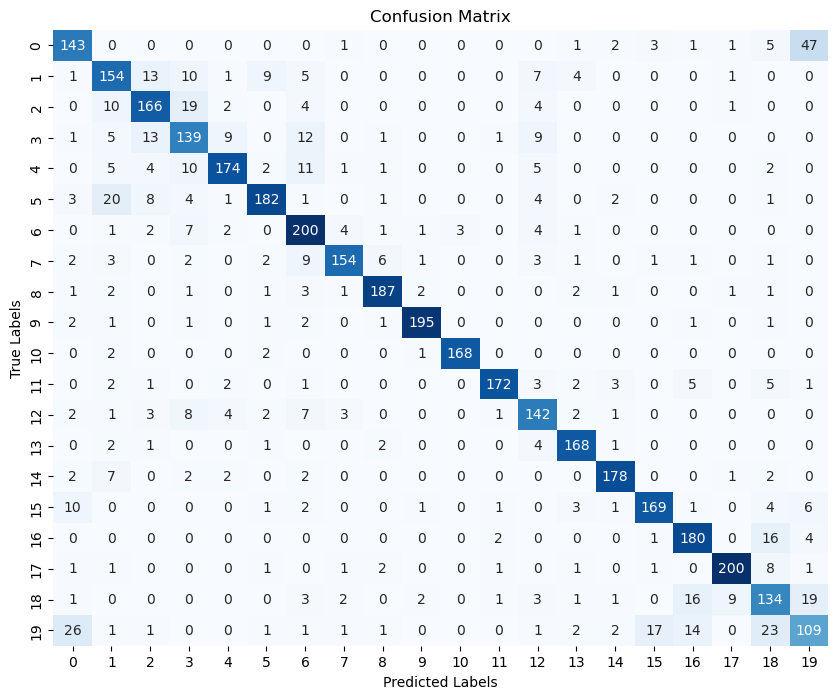

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(test_df['Newsgroup'], y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

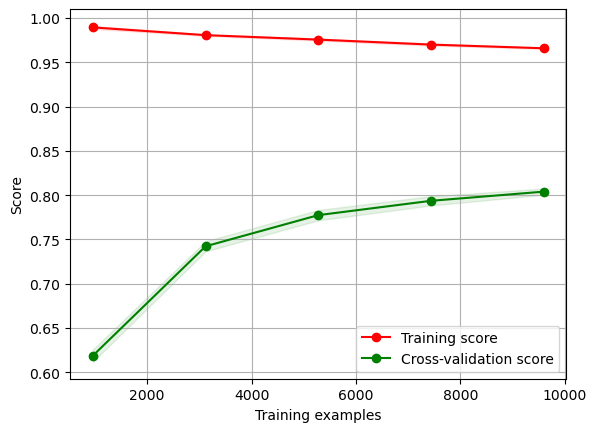

In [ ]:
def plot_learning_curve(estimator, X, y, title=None, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    if title is not None:
        plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curves
plot_learning_curve(best_fine_tuned_model, X_train_spacy_tfidf, train_df['Newsgroup'], cv=5)
plt.show()

In [ ]:
train_df.to_csv('train_df.csv', index=False)
val_df.to_csv('val_df.csv', index=False)
test_df.to_csv('test_df.csv', index=False)


In [ ]:
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)


In [ ]:
for model_name, model in models.items():
    with open(f'{model_name}_model.pkl', 'wb') as f:
        pickle.dump(model, f)


In [ ]:
plt.savefig('learning_curve.png')


<Figure size 640x480 with 0 Axes>

In [ ]:
with open('best_model.pkl', 'wb') as f:
    pickle.dump(models[best_model[0]], f)


In [ ]:
with open('results_df.pkl', 'wb') as f:
    pickle.dump(results_df, f)


In [ ]:
with open('best_fine_tuned_model.pkl', 'wb') as f:
    pickle.dump(best_fine_tuned_model, f)
